#  MIDS W207 

## Authors: Neha Kumar, Suhas Gupta
## Submission Data: 04/06/2019 

# Problem Description

We are given a set of training data from Kaggle (https://www.kaggle.com/c/sf-crime/leaderboard) and a set of test data. Given the features in the test data, we need to classify the type of crime. The fields in the dataset are summarized below. Primarily, our dataset is comprised of location and temporal data (where and when was the crime created). Note that there are some datasets that cannot be used for training the model, as they are not accessible to the test model (such as the Descript and Resolution parameters), though we can definitely look to these fields in our error analysis.

Additionally, we plan on using feature engineering to extract useful parameters from the termporal and location data, further detailed below. This, in conjunction with using classification-based models, will aid us in producing a model with the smallest log-loss score (the evaluation criteria for this Kaggle competition)

## Competition data set details from Kaggle

### Data fields
- Dates - timestamp of the crime incident
- Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude

The variables we can use to generate the model will need to be in both the train and test dataset. This gives us:
- Dates
- DayOfWeek
- PdDistrict
- Address
- X
- Y

In [1]:
# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import json
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

# SK-learn libraries for learning and preprocessing
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Libraries for imbalanced classes
import imblearn 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
# Set the figure size for seaborn plots
sns.set(rc={'figure.figsize':(15,15)})

We selected the SF Crime competition

https://www.kaggle.com/c/sf-crime/data

## Data Import and EDA

In [2]:
# Define a data pre processing class

class import_EDA:
    '''
        Parameters: 
        Methods: 
          
    '''
    def __init__(self,trainCSV='./train.csv',testCSV='./test.csv'):
        """Create a new instance of the data import and EDA class object
        Parameters:
            trainCSV: CSV file containing training data 
            testCSV: CSV file containing test data used by Kaggle for model evaluation
            
        """
        self._trainCSV = trainCSV
        self._testCSV = testCSV
        self._train = pd.DataFrame()
        self._test = pd.DataFrame()

    def importToPandas(self):
        '''Import the CSV files and return pandas data frames'''
        self._train=pd.read_csv(self._trainCSV)
        self._test=pd.read_csv(self._testCSV)
        return self._train,self._test
    
    def displayDataFrame(self,dataFrame,rows=5):
        #dataFrame.style.format()
        display(dataFrame[:rows])
        
    def featureDiff(self,train,test):
        diff = set(train.columns) - set(test.columns)
        return diff
    
    def plotDFDistribution(self,dataFrame,categoryName):
        g = sns.countplot(data = dataFrame, x = categoryName,orient='h',)
        plt.ylabel("Total Count")
        plot_obj = plt.xticks(rotation=90)
        return plot_obj
    
    def plotDistGrid(self,dataFrame,plot_list,rows,cols):
        counter = 0
        fig, axs = plt.subplots(ncols=cols,nrows=rows)
        for row in range(0,rows):
            for col in range(0,cols):
                sns.countplot(data = dataFrame, x = plot_list[counter],orient='h',ax=axs[row,col])
                axs[row,col].tick_params(axis='x', rotation=90)
                counter+=1
        return fig,a
    
    def plotColdist(self,dataFrame,colName):  
        '''Plot colName data grouped by day of the week and hour of the day'''
        fig, axes = plt.subplots(nrows=8, ncols=5, sharex=False, sharey=False, figsize = (16, 20))
        plt.subplots_adjust(top = 1.1)
        
        all_categories = dataFrame[colName].value_counts().index.tolist()
        for category in range(len(all_categories)):
            my_cat = all_categories[category]
            df = dataFrame.loc[dataFrame[colName] == my_cat,:]
            df = df.groupby(['Hour','DayOfWeek']).count()['X']
            df = df.reset_index(level='Hour').reset_index(level = 'DayOfWeek')
            df = df.pivot(index='Hour', columns='DayOfWeek', values='X').reset_index()

            ax = plt.subplot(8, 5, category + 1)  
            hour = df['Hour'].values 
            days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
            colors = ['red','orange','yellow','green','blue','purple','pink']

            for i in range(len(days)):
                if days[i] in df.columns:
                    ax.plot(hour,df[days[i]].values, colors[i])
            ax.set_title(my_cat)
            
        return ax

    def describeData(self,dataFrame):
        # Find if there are any NA values in the data frame columns 
        if(dataFrame.isnull().values.any()):
            null_values_bool = 0
        else:
            null_values_bool = 1
        row_count = len(dataFrame)
        dataTypes = dataFrame.dtypes
        return null_values_bool,row_count,dataTypes
   
    def splitDate(self,train,test):
        '''This method will import new data frames if not passed from function call
           and split the date column in year, month, hour, minutes'''
        
        # Get years
        train['Year'] = (pd.to_numeric(train['Dates'].str.split('-').str[0])).astype('int16')
        test['Year'] = (pd.to_numeric(test['Dates'].str.split('-').str[0])).astype('int16')
        
        # Get months
        train['Month'] = (pd.to_numeric(train['Dates'].str.split('-').str[1])).astype('int8')
        test['Month'] = (pd.to_numeric(test['Dates'].str.split('-').str[1])).astype('int8')
       
        # Get day
        train['DayOfMonth'] = pd.to_numeric(train['Dates'].str.split(' ').str[0].str.split('-').str[2]).astype('int8')
        test['DayOfMonth'] = pd.to_numeric(test['Dates'].str.split(' ').str[0].str.split('-').str[2]).astype('int8')
       
        # Get hour of the day
        train['Hour'] = (pd.to_datetime(train['Dates'],infer_datetime_format=True).dt.hour).astype('float64')
        test['Hour'] = (pd.to_datetime(test['Dates'],infer_datetime_format=True).dt.hour).astype('float64')
        
        # Get minutes of the hour
        train['Minutes'] = pd.to_numeric(train['Dates'].str.split(' ').str[1].str.split(':').str[1]).astype('int8')
        test['Minutes'] = pd.to_numeric(test['Dates'].str.split(' ').str[1].str.split(':').str[1]).astype('int8')
        
        return train, test
    
    def generateZipCodes(self,dataFrame,zip_list):
        # Building a KNN Model with n_neighbors = 1 on the lat/long coordinates
        zip_features = zip_list[['longitude','latitude']]
        zip_features.columns = ['X', 'Y']
        zip_data = zip_features.values
        zip_labels = zip_list['zip_code'].values
        zip_prediction_set = dataFrame[['X','Y']].values

        knn_zip = KNeighborsClassifier(n_neighbors = 1)
        predictions = knn_zip.fit(zip_data, zip_labels).predict(zip_prediction_set)

        # Add the generated zip codes to the data frame
        dataFrame['Zipcode'] = predictions
        return dataFrame
    
    def addUSHolidays(self,dataFrame):
        '''Check for US holidays based on the Dates and add a boolean feature indicating a holiday or not'''
        # Checking for US Holidays
        # Load in holidays dataframe (source: https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020)
        holidays = pd.read_csv('./usholidays.csv')

        # Make is_holiday flag
        dates_train = (dataFrame['Dates'].str.split(' ').str[0])
        dataFrame['is_holiday'] = dates_train.isin(holidays.Date).astype('int8')
        proportion_holidays = dataFrame['is_holiday'].sum() / dataFrame.shape[0]

        return dataFrame


In [3]:
# Create importData_EDA object
dataImport = import_EDA()
train,test = dataImport.importToPandas()
sample_submission = pd.read_csv('sampleSubmission.csv')

In [4]:
# Check if the training of test sets have any NULL values
null_train,count_train,dTypes_train= dataImport.describeData(train)
null_test,count_test,dTypes_test = dataImport.describeData(test)

print("Number of rows in training dataset:{fm}".format(fm=count_train))
print("Number of rows in test dataset:{fm}".format(fm=count_test))

if(null_train==0):
    print("NULL values found in the training dataset")
else:
    print("No NULL values in the training dataset") 

if(null_test==0):
     print("NULL values found in the test dataset") 
else:
    print("No NULL values in the test dataset")
    
print("\n------------- Data Types[Training Data]-----------------\n")
print(dTypes_train)

print("\n------------- Data Types[Test Data]-----------------\n")
print(dTypes_test)

Number of rows in training dataset:878049
Number of rows in test dataset:884262
No NULL values in the training dataset
No NULL values in the test dataset

------------- Data Types[Training Data]-----------------

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

------------- Data Types[Test Data]-----------------

Id              int64
Dates          object
DayOfWeek      object
PdDistrict     object
Address        object
X             float64
Y             float64
dtype: object


- The output above shows that there are no missing values in the Kaggle datasets for both training and test data. Thus we do not need to account for missing values in our EDA and model development.

- We can also see from above, that all the variables except geographical coordinates (X,Y) are categorical. Thus we will need to perform feature encoding to enable the use of sklearn's modeling and prediction algorithms.

In [5]:
## Lets look at the first samples in the data sets

print("------------------------------------------- Top 5 rows in training dataset ------------------------------------------")
print("---------------------------------------------------------------------------------------------------------------------")
dataImport.displayDataFrame(train,5)

print("\n--------------------------------------------- Top 5 rows in test dataset --------------------------------------------")
print("---------------------------------------------------------------------------------------------------------------------\n")

dataImport.displayDataFrame(test,5)

print("\n-------------------------Features in training dataset not present in test dataset-------------------------\n")
diffFeatures = dataImport.featureDiff(train,test)
print(diffFeatures)

------------------------------------------- Top 5 rows in training dataset ------------------------------------------
---------------------------------------------------------------------------------------------------------------------


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541



--------------------------------------------- Top 5 rows in test dataset --------------------------------------------
---------------------------------------------------------------------------------------------------------------------



,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412



-------------------------Features in training dataset not present in test dataset-------------------------

{'Resolution', 'Category', 'Descript'}


#### Let us look at the distribution of outcome variable "Category"

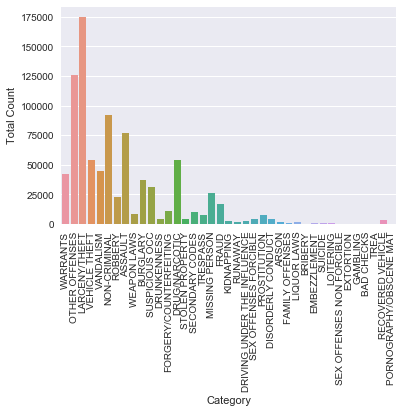

In [6]:
# Plot the distribution of the crime categories from the training data set
tmp = dataImport.plotDFDistribution(train,'Category')

The above plot shows the frequency distribution of the outcome variable **Category**. We can see that we have a heavy imbalance in the class counts. The most frequent crime cateogry is **LARCENY/THEFT** followed by **OTHER OFFSENSES** and **NON-CRIMINAL**. We will need to account for the heavy imbalance in our classes while choosing the appropriate training classifier model for our problem. A baseline model could just be one that predicts every outcome as LARCENY/THEFT.

In [7]:
# Create another instance of train,test data set for feature engineering
dataImport_v2 = import_EDA()
train_v2,test_v2= dataImport_v2.importToPandas()

# Split the date category to years,hours,months
train_v2,test_v2 = dataImport_v2.splitDate(train_v2,test_v2)

As a first step to our feature engineering, we extract the elements of the date to make them more usable. Here, we extract the year, the month, the day of the month, hour, and minutes. The goal of this step is to see if there is any periodic behavior with these components of time. For example, crime rates can overall be stable year after year, but fluctuate sesonally or on an hourly basis throughout the day. These fluctuations will be captured if we extract the date parts from the timestamp rather than using the full timestamp given in the original dataset

In [8]:
print('\nTraining data set after date split\n')
dataImport.displayDataFrame(train_v2,5)
      
print('\nTest data set after test split')
dataImport.displayDataFrame(test_v2,5)


Training data set after date split



,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23.0,33
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23.0,30
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23.0,30



Test data set after test split


,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23.0,59
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,10,23.0,51
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,10,23.0,50
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45


IndexError: list index out of range

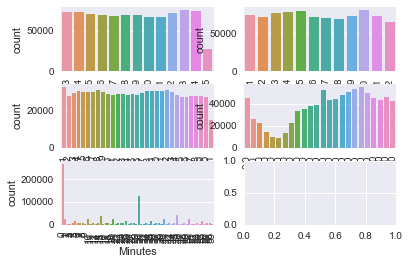

In [9]:
plot_list = ['Year','Month','DayOfMonth','Hour','Minutes']
fig,axs = dataImport_v2.plotDistGrid(train_v2,plot_list,3,2)

- All the years appear to be evenly distributed in the data set, i.e. there is no distinction boundary apparent in the crime categories from just the year data.
- Month:
- Day:
- Hour:

### Adding zip codes to the feature set

We wanted to add zipCode information as a way to group together locations that are close together. As the neighborhoods of SF are quite different from one another, we felt this would be a useful feature for our analysis

To get the Zip Codes, we first tried to use geopy's reverse geocode mapping to get the full address (With the zipcode) from the lat/long coordinates. However, we were hitting into a "too many requests" error. Best practices recommend we make 1 request per second. As our training dataset has about 800k records, running this API will take close to 10 days. 

As a result, we pivoted to another strategy. Using the information here https://community.periscopedata.com/t/q5kqgg/us-zip-codes-with-latitudelongitude, we got a CSV with all of the lat/long coordinates cooresponding to each zip code. We then used k nearest neighbors with this CSV as the training dataset (with KNN = 1) to find the zip code whose lat/long coordinate is closest to the crime locatiom.

As a caveat, this assumes that zip codes are circular regions (when in reality they are irregularly shaped). However, this approximation runs much faster than using an API, so we will use this way of determining zip codes.

       zip_code   latitude   longitude
39798     94101  37.784827 -122.727802
39799     94102  37.779278 -122.416582
39800     94103  37.775678 -122.412131
39801     94104  37.790728 -122.401732
39802     94105  37.789595 -122.395631


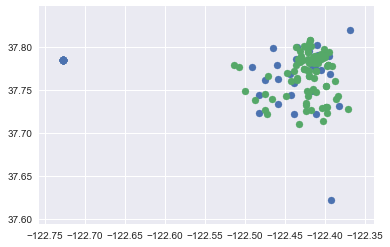

In [10]:
# Source of data https://community.periscopedata.com/t/q5kqgg/us-zip-codes-with-latitudelongitude
zips = pd.read_csv('zip_codes_states.csv')
sf_zips = zips[zips['city'] == 'San Francisco'][['zip_code','latitude','longitude']]

# Plotting the SF Zip code midpoints with some crime locations to ensure that the data pulled in via CSV makes ense
print(sf_zips[:5])
plt.scatter(sf_zips['longitude'],sf_zips['latitude'])
demo = train[:100]
plt.scatter(demo['X'],demo['Y'])

From the above, we see that the zip code center points (in blue) are in line with the first 100 features from our training dataset (green). This was a gut check to ensure that our zip code data that we imported in makes sense. Now we use KNN to generate the zip codes for our feature set

In [11]:
train_v2 = dataImport_v2.generateZipCodes(train_v2,sf_zips)
test_v2 = dataImport_v2.generateZipCodes(test_v2,sf_zips)

In [12]:
print('\nTraining data set after zipcode addition\n')
dataImport_v2.displayDataFrame(train_v2,5)
      
print('\nTest data set after zipcode addition')
dataImport_v2.displayDataFrame(test_v2,5)


Training data set after zipcode addition



,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes,Zipcode
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23.0,33,94109
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23.0,30,94109
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23.0,30,94117



Test data set after zipcode addition


,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes,Zipcode
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23.0,59,94124
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,10,23.0,51,94124
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,10,23.0,50,94109
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45,94112
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45,94112


Let's look at the distribution of the generated zip codes in the training and test data sets

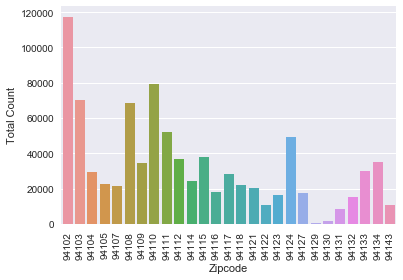

In [13]:
g = dataImport_v2.plotDFDistribution(train_v2,'Zipcode')

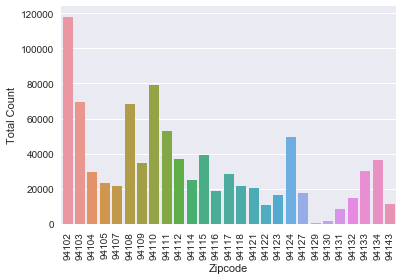

In [14]:
g = dataImport_v2.plotDFDistribution(test_v2,'Zipcode')

The zipcode distribution looks similar between training and test datasets

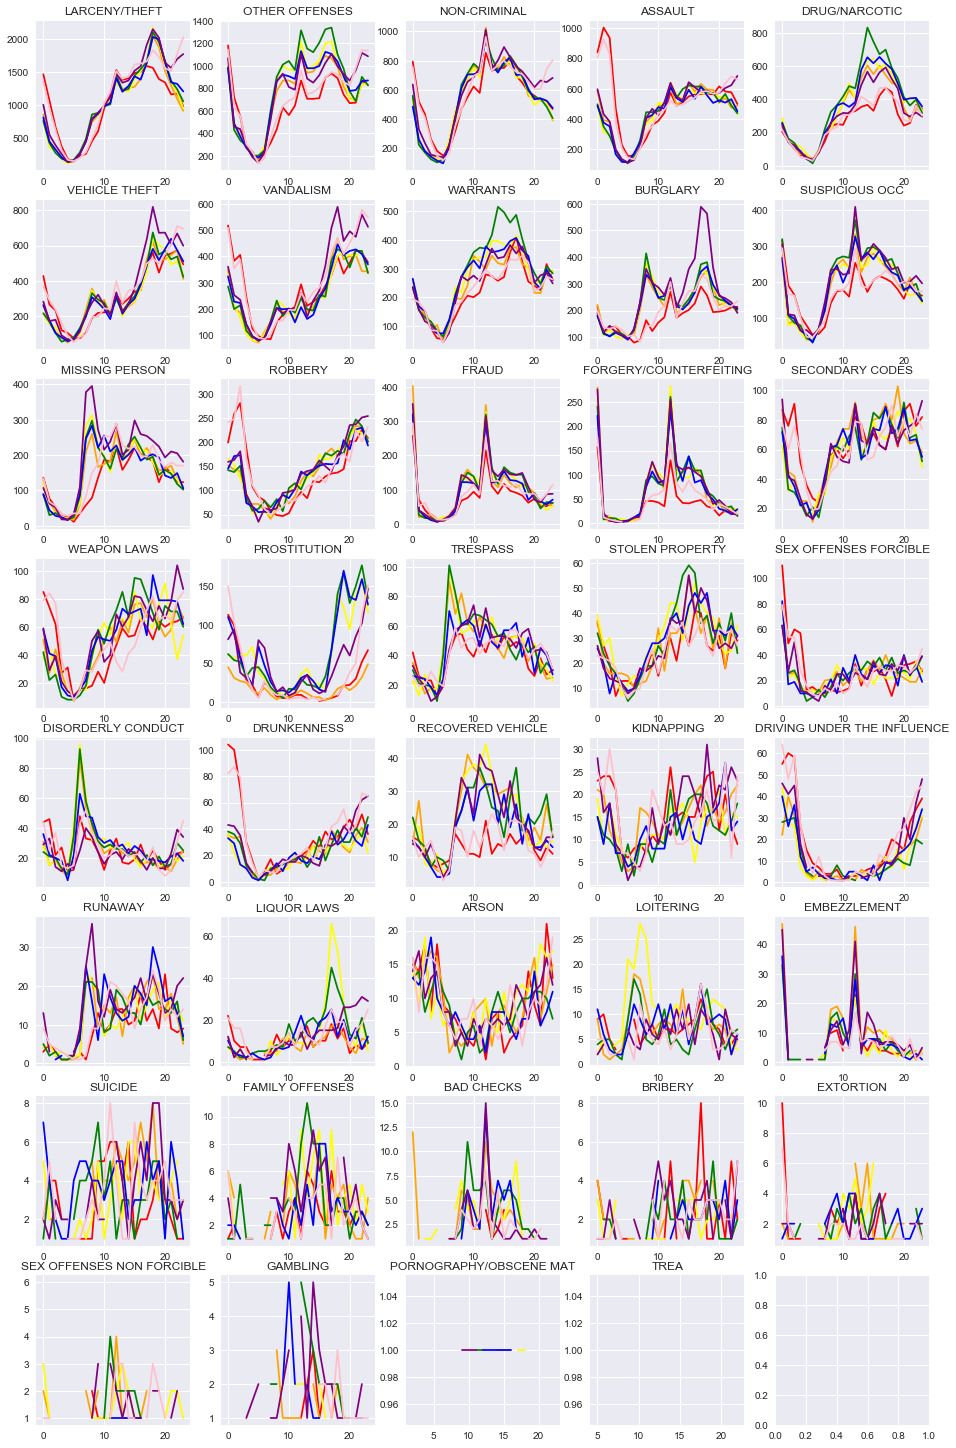

In [15]:
ax = dataImport_v2.plotColdist(train_v2,'Category')

Next, we want to add a marker on whether or not a day is a national holiday. We suspect this is a useful feature as more people are out and about / there are more tourists in San Francisco on national holidays. Thus, the crime patterns may differ on these days as opposed to other days. We used a Kaggle dataset of national holidays and compared the dates in the dataset to these holidays, adding a flag when a crime has occurred on a holiday.

In [16]:
train_v2 =  dataImport_v2.addUSHolidays(train_v2)
test_v2 =  dataImport_v2.addUSHolidays(test_v2)

print('\nTraining data set after is_holiday addition\n')
dataImport_v2.displayDataFrame(train_v2,5)
      
print('\nTest data set after is_holiday addition')
dataImport_v2.displayDataFrame(test_v2,5)


Training data set after is_holiday addition



,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes,Zipcode,is_holiday
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23.0,33,94109,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23.0,30,94109,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23.0,30,94117,0



Test data set after is_holiday addition


,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes,Zipcode,is_holiday
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23.0,59,94124,0
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,10,23.0,51,94124,0
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,10,23.0,50,94109,0
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45,94112,0
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45,94112,0


In [17]:
## Calculate fraction of crimes committed on holidays
proportion_holidays = train_v2['is_holiday'].sum() / train_v2.shape[0]
print('The proportion of crime records on US recognized holidays is {fm}%'.format(fm=100*round(proportion_holidays,5)))
print('The proportion of crime records NOT on US recognized holidays is {fm}%'.format(fm=100*round(1 - proportion_holidays,5)))


The proportion of crime records on US recognized holidays is 2.866%
The proportion of crime records NOT on US recognized holidays is 97.134%


In [18]:
## Deal with geo-coordinates
# Remove latitude of 90 degress (this indicates north pole which points to incorrect data collection or recording)
train_v2 = train_v2[train_v2.Y < 90]

In [19]:
dataImport_v2.displayDataFrame(train_v2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes,Zipcode,is_holiday
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23.0,33,94109,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23.0,30,94109,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23.0,30,94117,0


## Feature Engineering

In [20]:
class createTestTrainData:
    '''
        Parameters: 
            trainDataFrame: Pandas DF containing training data
            testDataFrame: Pandas DF containing test data
            outcome : [String] Predicted variable name in the data frame
            removeCategories: [List] Categories to be removed from the training data frame to match test data shape
            trainDataEncoded: Numpy data array containing encoded feature set for training data
            trainlabelsEncoded: Numpy data array containing encoded dataset for training labels
            mini_size: Size of the mini training data and label set to create
            r_seed: Random seed for test train split 
            t_size: Size of dev dataset
            shuffle: Boolean indicating shuffling of data for test train split
            
        Methods: 
            getDataSets(): Converts the pandas data frames for test and training data to numpy arrays for modeling
            testTrainSplit(): Splits dataset into training and development data sets         

    '''
    def __init__(self,trainDataFrame=pd.DataFrame(),testDataFrame=pd.DataFrame(),outcome='Category',
                 removeCategoriesTrain=['Category','Descript','Resolution'],
                 removeCategoriesTest= ['Category','Descript','Resolution'],
                 trainDataEncoded=[],trainlabelsEncoded=[], 
                 mini_size = 1000, r_seed = 1, t_size = 0.20, shuffle=True):
        
        # Parameters for data set creation
        self._trainDataFrame = trainDataFrame
        self._testDataFrame = testDataFrame
        self._remCatsTrain = removeCategoriesTrain  # categories to remove from the training dataset
        self._remCatsTest = removeCategoriesTest  # categories to remove from the test dataset

        self._labelCat = outcome # define the outcome category
        
        # Parameters for test train data split
        self._r_seed = r_seed
        self._shuffle = shuffle
        self._t_size = t_size
        self._mini_size = mini_size
        self._encodedData = trainDataEncoded
        self._encodedLabels = trainlabelsEncoded
 
    def getDataSets(self):
        """ Process pandas dataframe and return numpy arrays """
        
        data_train_df = self._trainDataFrame.drop(self._remCatsTrain,axis=1)
        labels_train_df = pd.DataFrame(self._trainDataFrame, columns = [self._labelCat])

        ## Convert data frame to numpy arrays
        data_train = data_train_df.values
        labels_train = labels_train_df.values
        ## Store the feature names in a list
        train_features_names = list(data_train_df.keys())
        ## Remove ID column from test data
        self._testDataFrame = self._testDataFrame.drop(self._remCatsTest,axis=1)
        test_data = self._testDataFrame.values
        test_feature_names = list(self._testDataFrame.keys())
        
        return data_train,labels_train,test_data,train_features_names,test_feature_names
    
    def testTrainSplit(self):
        """ Split into training, dev and mini training data sets """
        train_data, dev_data, train_labels, dev_labels = train_test_split(self._encodedData, self._encodedLabels,test_size = self._t_size, random_state = self._r_seed,shuffle=self._shuffle)
        mini_train_data, mini_train_labels = train_data[:self._mini_size], train_labels[:self._mini_size]
        return train_data, dev_data, mini_train_data, train_labels, dev_labels, mini_train_labels
    

In [35]:
# Define a data pre processing class

class featureProcessor:
    '''
        Parameters: 
            dataset: Numpy array containing data with features and samples 
            encode: Boolean indicating encoding of data
            encodeScheme: String value indicating scheme to use for encoding 
 
        Methods: 
            encodeTrainData(): Encodes the data using encodeScheme and returns transformed datasets
            encodeLabels(): Encodes the labels using encodeScheme and returns transformed label sets and class names

    '''
    
    def __init__(self,encode=0,dataencodeScheme='oneHot',labelEncodeScheme='label'):
        """Create a new instance of the preprocessing object
        Parameters: 
            encode : Binary [1: encode based on encodeScheme ; 0 : no encoding]
            dataencodeScheme: Scheme for encoding data set
            labelEncodeScheme: Scheme for encoding label data
        """
        self._encode = encode
        self._dataEncodeScheme = dataEncodeScheme
        self._labelEncodeScheme = labelEncodeScheme
        self._dataencoders = {'oneHot': preprocessing.OneHotEncoder()}
        self._labelencoders = {'label': preprocessing.LabelEncoder()}
        
        ## Test for argument fidelity
        if (self._encode and (self._dataEncodeScheme=="NULL" or self._labelEncodeScheme=="NULL")):
            raise ValueError("encode schemes for data or labels can't be NULL when encode !=0")     
        if (self._dataEncodeScheme not in self._dataencoders):
            raise ValueError("{fm} is not a valid encoding scheme defined in featureProcessor".format(fm=self._dataEncodeScheme))
        if (self._labelEncodeScheme not in self._labelencoders):
            raise ValueError("{fm} is not a valid encoding scheme defined in featureProcessor".format(fm=self._labelEncodeScheme))

    def columnTransform(self,num_features,cat_features):
        '''Encode both categorical and numeric data'''
        
        # Numeric encoding setup
        numeric_features = num_features
#         print('Numerical Features Are', num_features)
#         print(train_features_names_v2)
        #numeric_transformer = preprocessing.StandardScaler()
        numeric_transformer = preprocessing.MinMaxScaler(copy=True, feature_range=(0, 1))                                                           
        
        #Categorical encoding setup
        categorical_features = cat_features
#         print('Categorical Features Are', categorical_features)
#         print(train_features_names_v2)
        categorical_transformer = self._dataencoders[self._dataEncodeScheme]
        
        # Create an encoding pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)])
    
        return preprocessor
    
    def encodeData(self,dataset,train_feature_names):
        # Define indeces for categorical and numerical features
        num_features=[train_features_names_v2.index('X'),train_features_names_v2.index('Y')]
        cat_features = [i for i,v in enumerate(train_features_names_v2) if i not in num_features]
        if self._encode:
            preprocessor = self.columnTransform(num_features,cat_features)
            transformedDataset = preprocessor.fit_transform(dataset)
        else:
            transformedDataset = dataset
        
        return transformedDataset
    
    def encodeLabels(self,labelset):        
        # Encode label data
        enc = self._labelencoders[self._labelEncodeScheme]
        if self._encode:
            transformedLabelset = enc.fit_transform(np.ravel(labelset.reshape(-1,1)))
            data_classes = enc.classes_
        else:
            transformedLabelset = labelset
            data_classes = np.unique(transformedLabelset)
        return transformedLabelset,data_classes

In [40]:
''' FOR v2 DATA: Import the data frames into numpy arrays and remove extraneous categories 
    Outcome Variable: Category [This is what we will predict and it forms a separate array]
'''
removeCatsTrain_v2 = ['Category','Descript','Resolution', 'Dates']
removeCatsTest_v2 = ['Id', 'Dates']

outcomeLabel = 'Category' 
importdata_v2 = createTestTrainData(trainDataFrame=train_v2,testDataFrame=test_v2,outcome=outcomeLabel,
                                    removeCategoriesTrain=removeCatsTrain_v2,removeCategoriesTest=removeCatsTest_v2)
data_train_v2,labels_train_v2,test_data_v2,train_features_names_v2,test_feature_names_v2 = importdata_v2.getDataSets()

# Check shape of all arrays
print('Shape of training data: {train_shp1}'.format(train_shp1=data_train_v2.shape))
print('Shape of training labels: {train_shp2}'.format(train_shp2=labels_train_v2.shape))
print('List of training features:', train_features_names_v2)
print('Shape of test data:', test_data_v2.shape)
print('List of test features:', test_feature_names_v2)

print(data_train_v2[1,:])
print(test_data_v2[1,:])

Shape of training data: (877982, 12)
Shape of training labels: (877982, 1)
List of training features: ['DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'Year', 'Month', 'DayOfMonth', 'Hour', 'Minutes', 'Zipcode', 'is_holiday']
Shape of test data: (884262, 12)
List of test features: ['DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'Year', 'Month', 'DayOfMonth', 'Hour', 'Minutes', 'Zipcode', 'is_holiday']
['Wednesday' 'NORTHERN' 'OAK ST / LAGUNA ST' -122.425891675136
 37.7745985956747 2015 5 13 23.0 53 94102 0]
['Sunday' 'BAYVIEW' '3RD ST / REVERE AV' -122.391522893042
 37.7324323864471 2015 5 10 23.0 51 94124 0]


In [41]:
''' FOR V2 DATA: Encoded data using one Hot Encoding'''
dataEncodeScheme = 'oneHot' # use one Hot scheme
labelEncodeScheme  = 'label' # use label encoder (category to ordered numeric)
encode = 1  # to encode or not to encode
fp_v2 = featureProcessor(encode,dataEncodeScheme,labelEncodeScheme)   

data_train_encoded_v2 = fp_v2.encodeData(data_train_v2,train_features_names_v2)
test_data_encoded_v2 = fp_v2.encodeData(test_data_v2,train_features_names_v2)
labels_train_encoded_v2, data_classes_v2 = fp_v2.encodeLabels(labels_train_v2)
print('\nData classes :', data_classes_v2[:5])
  

'''Split data in train, dev and mini_train dataset for training and validating models'''
random_seed = 1
dev_size = 0.20 # Set dev data set size to 20%
shuffle = True # Shuffle the data based on random seed
mini_dataset_size = 1000
splitData_v2 = createTestTrainData(trainDataEncoded = data_train_encoded_v2,trainlabelsEncoded=labels_train_encoded_v2, 
                 mini_size = mini_dataset_size, r_seed=random_seed, t_size = dev_size, shuffle=shuffle)
train_data_v2, dev_data_v2, mini_train_data_v2, train_labels_v2, dev_labels_v2, mini_train_labels_v2 = splitData_v2.testTrainSplit()

# Check shapes of all arrays
print('Shape of encoded training data:',train_data_v2.shape)
print('Shape of encoded test data: ', test_data_encoded_v2.shape) 
print('Shape of encoded labels:', train_labels_v2.shape)
print('Shape of data classes:', data_classes_v2.shape)
print('Shape of dev dataset:',dev_data_v2.shape)
print('Shape of dev label dataset:',dev_labels_v2.shape)
print('Shape of mini training dataset:',mini_train_data_v2.shape)
print('Shape of mini label dataset:',mini_train_labels_v2.shape)

print(np.min(data_train_encoded_v2,axis=0))


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Data classes : ['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY']
Shape of encoded training data: (702385, 23379)
Shape of encoded test data:  (884262, 23372)
Shape of encoded labels: (702385,)
Shape of data classes: (39,)
Shape of dev dataset: (175597, 23379)
Shape of dev label dataset: (175597,)
Shape of mini training dataset: (1000, 23379)
Shape of mini label dataset: (1000,)



Pausing here, we see that the encoded test data has a slightly different number of columns than the training and dev data. This reveals a flaw in the encoding set-up, we don't have a way to distinguish which features are included in both dataset. We will remove the Address parameter (as this location data is also provided via the X and the Y), as the test and the train data are aligned and will have the same encoded features there.

In [42]:
''' FOR v2 DATA: Import the data frames into numpy arrays and remove extraneous categories 
    Outcome Variable: Category [This is what we will predict and it forms a separate array]
'''
removeCatsTrain_v2 = ['Category','Descript','Resolution', 'Dates', 'Address']
removeCatsTest_v2 = ['Id', 'Dates', 'Address']

outcomeLabel = 'Category' 
importdata_v2 = createTestTrainData(trainDataFrame=train_v2,testDataFrame=test_v2,outcome=outcomeLabel,
                                    removeCategoriesTrain=removeCatsTrain_v2,removeCategoriesTest=removeCatsTest_v2)
data_train_v2,labels_train_v2,test_data_v2,train_features_names_v2,test_feature_names_v2 = importdata_v2.getDataSets()

# Check shape of all arrays
print('Shape of training data: {train_shp1}'.format(train_shp1=data_train_v2.shape))
print('Shape of training labels: {train_shp2}'.format(train_shp2=labels_train_v2.shape))
print('List of training features:', train_features_names_v2)
print('Shape of test data:', test_data_v2.shape)
print('List of test features:', test_feature_names_v2)

print(data_train_v2[1,:])
print(test_data_v2[1,:])

Shape of training data: (877982, 11)
Shape of training labels: (877982, 1)
List of training features: ['DayOfWeek', 'PdDistrict', 'X', 'Y', 'Year', 'Month', 'DayOfMonth', 'Hour', 'Minutes', 'Zipcode', 'is_holiday']
Shape of test data: (884262, 11)
List of test features: ['DayOfWeek', 'PdDistrict', 'X', 'Y', 'Year', 'Month', 'DayOfMonth', 'Hour', 'Minutes', 'Zipcode', 'is_holiday']
['Wednesday' 'NORTHERN' -122.425891675136 37.7745985956747 2015 5 13 23.0
 53 94102 0]
['Sunday' 'BAYVIEW' -122.391522893042 37.7324323864471 2015 5 10 23.0 51
 94124 0]


In [43]:
''' FOR V2 DATA: Encoded data using one Hot Encoding'''
dataEncodeScheme = 'oneHot' # use one Hot scheme
labelEncodeScheme  = 'label' # use label encoder (category to ordered numeric)
encode = 1  # to encode or not to encode
fp_v2 = featureProcessor(encode,dataEncodeScheme,labelEncodeScheme)   

data_train_encoded_v2 = fp_v2.encodeData(data_train_v2,train_features_names_v2)
test_data_encoded_v2 = fp_v2.encodeData(test_data_v2,train_features_names_v2)
labels_train_encoded_v2, data_classes_v2 = fp_v2.encodeLabels(labels_train_v2)
print('\nData classes :', data_classes_v2[:5])
  

'''Split data in train, dev and mini_train dataset for training and validating models'''
random_seed = 1
dev_size = 0.20 # Set dev data set size to 20%
shuffle = True # Shuffle the data based on random seed
mini_dataset_size = 1000
splitData_v2 = createTestTrainData(trainDataEncoded = data_train_encoded_v2,trainlabelsEncoded=labels_train_encoded_v2, 
                 mini_size = mini_dataset_size, r_seed=random_seed, t_size = dev_size, shuffle=shuffle)
train_data_v2, dev_data_v2, mini_train_data_v2, train_labels_v2, dev_labels_v2, mini_train_labels_v2 = splitData_v2.testTrainSplit()

# Check shapes of all arrays
print('Shape of encoded training data:',train_data_v2.shape)
print('Shape of encoded test data: ', test_data_encoded_v2.shape) 
print('Shape of encoded labels:', train_labels_v2.shape)
print('Shape of data classes:', data_classes_v2.shape)
print('Shape of dev dataset:',dev_data_v2.shape)
print('Shape of dev label dataset:',dev_labels_v2.shape)
print('Shape of mini training dataset:',mini_train_data_v2.shape)
print('Shape of mini label dataset:',mini_train_labels_v2.shape)

print(np.min(data_train_encoded_v2,axis=0))


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Data classes : ['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY']
Shape of encoded training data: (702385, 188)
Shape of encoded test data:  (884262, 188)
Shape of encoded labels: (702385,)
Shape of data classes: (39,)
Shape of dev dataset: (175597, 188)
Shape of dev label dataset: (175597,)
Shape of mini training dataset: (1000, 188)
Shape of mini label dataset: (1000,)



Now the encoded feature count matches between the training, dev and test data. We will proceed with this sample.

### PCA
#### used TruncatedSVD as this is better for Sparse inputs

Note: In our earlier submission, we had fewer features in our dataset. Since increasing the number of features (adding the day of month for example), we re-evaluated the need for PCA and saw that the PCA curve more clearly tapers off now with the larger number of features. We will see if this translates to a more robust model. If the model is more robust with PCA, we will keep the PCA features for the rest of our modeling

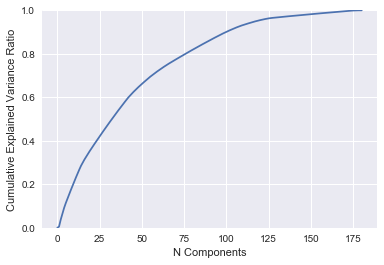

In [44]:
# Number of variables we will use in PCA
n = 180

# Running the PCA
pca = TruncatedSVD(n_components = n)
pca.fit(train_data_v2)

# Calculate sum of the EVR
evr = np.concatenate(([0], pca.explained_variance_ratio_))
sevr = np.cumsum(evr)
    
# Plotting cumulative sum
plt.plot(range(n + 1),sevr)
plt.xlabel('N Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.ylim([0,1])
plt.show()

It looks like the explained variance ratio tapers off at a dimensionality greater than 150. However, there is no clear cut-off point. Let's pivot to L1 to tell us the most key features

In [48]:
c_vals = [0.001, 0.005, 0.01, 0.05, 0.1]
feature_count_v1 = []
nonzero_idx_list_v1 = []

for idx_c, c in enumerate(c_vals):
    
    # Train the linear regression model using L1 regularization
    l1 = LogisticRegression(penalty='l1', C = c, solver = 'saga', multi_class='auto', tol=.01)
    l1_model = l1.fit(train_data_v2, train_labels_v2)
    
    # Get the indices of the non zero features and save them
    summed_weights = np.sum(l1_model.coef_, axis=0)
    nonzero_index = np.nonzero(summed_weights)[0]
    nonzero_idx_list_v1.append(nonzero_index) 
    n_features = len(nonzero_index)
    feature_count_v1.append(n_features)
    print('For a c of', c, 'the number of non zero features is', n_features)
    
    # Break the loop if L1 regularization is no longer removing any features for us
    if n_features >= train_data_v2.shape[1]:
        break

For a c of 0.001 the number of non zero features is 47
For a c of 0.005 the number of non zero features is 127
For a c of 0.01 the number of non zero features is 144
For a c of 0.05 the number of non zero features is 184
For a c of 0.1 the number of non zero features is 188


In [50]:
all_feature_sets_train = []
all_feature_sets_dev = []
all_feature_sets_test = []

for i in range(len(c_vals)):
    idx = nonzero_idx_list_v1[i]
    all_feature_sets_train.append(train_data_v2[:,idx])
    all_feature_sets_dev.append(dev_data_v2[:,idx])
    all_feature_sets_test.append(test_data_encoded_v2[:,idx])
    

In [53]:
# Check to make sure our datasets are the right size

for i in range(len(all_feature_sets_train)):
    print(all_feature_sets_train[i].shape)

(702385, 47)
(702385, 127)
(702385, 144)
(702385, 184)
(702385, 188)



## Model development and training

In [54]:
from imblearn.pipeline import make_pipeline as imbPipeline
unique,counts = np.unique(train_labels_v2,return_counts=True)
label_count_dict = dict(zip(unique, counts))
under_sample_dict = dict(label_count_dict)
sample_count = 10000

for label,count in label_count_dict.items():
    if count >= sample_count:
        under_sample_dict[label]=sample_count

over_sample_dict = dict(under_sample_dict)
for label,count in label_count_dict.items():
    if count <= sample_count:
        over_sample_dict[label]=sample_count

rus = RandomUnderSampler(sampling_strategy=under_sample_dict,random_state=random_seed)
ros = RandomOverSampler(sampling_strategy=over_sample_dict,random_state=random_seed)
clf = DecisionTreeClassifier(min_samples_split=20,max_depth=8)
pipeline = imbPipeline(rus,ros,clf)

pipeline.fit(train_data_v2,train_labels_v2)
score = pipeline.score(dev_data_v2,dev_labels_v2)
print(score)


0.10976269526244753


### Multinomial Naive Bayes¶


In [55]:
#For V2 data

mnb_v2 = MultinomialNB()
alphas = {'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0,20,50,100,500,1000]}
# GridSearchCV uses negative log loss so it can maximize this parmater
mnb_v2_cv = GridSearchCV(estimator = mnb_v2, param_grid = alphas, cv = 3, scoring = 'neg_log_loss', n_jobs=-1)
nb_v2 = mnb_v2_cv.fit(train_data_v2, train_labels_v2)

In [56]:
# # For V2 data

print('The best value for alpha (with feature engineering) is:', nb_v2.best_params_['alpha'])
print('Best score from grid search on training data set \
      (with feature engineering):{fm}'.format(fm=round(nb_v2.best_score_,4)))


The best value for alpha (with feature engineering) is: 2.0
Best score from grid search on training data set       (with feature engineering):-2.4826


Before we jump to conclusions that this is the best value for alpha, let's check for underfitting/overfitting on the dev data

Running alpha of 1e-07
Running alpha of 1e-06
Running alpha of 1e-05
Running alpha of 0.0001
Running alpha of 0.001
Running alpha of 0.01
Running alpha of 0.1
Running alpha of 0.5
Running alpha of 1.0
Running alpha of 2.0
Running alpha of 10.0
Running alpha of 20
Running alpha of 50
Running alpha of 100
Running alpha of 500
Running alpha of 1000


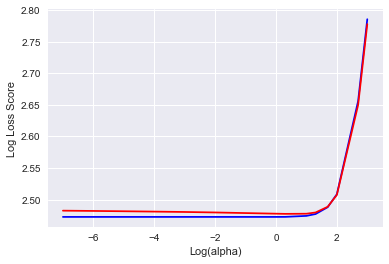

[2.4725357179687233, 2.47253572090918, 2.472535750157195, 2.472536028036284, 2.4725379343344427, 2.47254266467544, 2.4725341934733396, 2.472528032900347, 2.4725431588615407, 2.4726086696986367, 2.4741542202670908, 2.4770791843921907, 2.4879298647379477, 2.508485655108296, 2.655982581999316, 2.7856585808908387]
[2.4824374288006714, 2.4819915953405123, 2.481488725533137, 2.4809384607631992, 2.480354864908361, 2.4795810668369267, 2.478623717361002, 2.4779388143040015, 2.4776451786046327, 2.4773563663544316, 2.4775866112908864, 2.4795462289763686, 2.4885785212262648, 2.507319887094637, 2.649868106657825, 2.7779105128083574]


In [57]:
# For V2 data

train_scores = []
dev_scores = []

alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0,20,50,100,500,1000]
for a in alphas:
    print('Running alpha of',a)
    mnb_v2 = MultinomialNB(alpha = a)
    train_predict = mnb_v2.fit(train_data_v2, train_labels_v2).predict_proba(train_data_v2)
    train_score = metrics.log_loss(train_labels_v2, train_predict)
    train_scores.append(train_score)
    dev_predict = mnb_v2.predict_proba(dev_data_v2)
    dev_score = metrics.log_loss(dev_labels_v2,dev_predict)
    dev_scores.append(dev_score)

    
# Plotting log loss scores
plt.plot(np.log10(alphas),train_scores, 'blue')
plt.plot(np.log10(alphas),dev_scores, 'red')
plt.xlabel('Log(alpha)')
plt.ylabel('Log Loss Score')
plt.show()

# Print outputs
print(train_scores)
print(dev_scores)

From the above plot, we see that the Log-Loss score is indeed ideal for both the training and test dataset at an alpha of 2.0. We are not at risk of over or underfitting atthese values comparied to other values of alpha

In [58]:
# For V2 data

best_alpha_v2 = nb_v2.best_params_['alpha']
mnb_v2_optimized = MultinomialNB(alpha = best_alpha_v2)
mnb_v2_optimized.fit(train_data_v2, train_labels_v2)
pred_labels_v2 = mnb_v2_optimized.predict(dev_data_v2)
mnb_v2_score = metrics.f1_score(dev_labels_v2, pred_labels_v2, average = 'micro')
mnb_v2_log_loss = metrics.log_loss(dev_labels_v2, mnb_v2_optimized.predict_proba(dev_data_v2))

print('The F1 score for a Multinomial Naive Bayes model (with feature engineering) is {fm}'.format(fm=round(mnb_v2_score,4)))
print("Log loss for Multinomial Naive Bayes is {fm}".format(fm=mnb_v2_log_loss))


The F1 score for a Multinomial Naive Bayes model (with feature engineering) is 0.2597
Log loss for Multinomial Naive Bayes is 2.4773563663544316


### Running with different feature subsets (taking only nonzero features from L1 optimization)

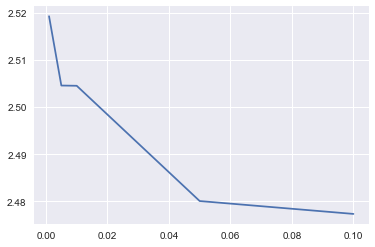

In [61]:
mnb_log_losses = []

for i in range(len(c_vals)):
    mnb_v2_trim_features = MultinomialNB(alpha = best_alpha_v2)
    mnb_v2_trim_features.fit(all_feature_sets_train[i], train_labels_v2)
    mnb_log_loss = metrics.log_loss(dev_labels_v2, mnb_v2_trim_features.predict_proba(all_feature_sets_dev[i]))
    mnb_log_losses.append(mnb_log_loss)
    
plt.plot(c_vals, mnb_log_losses)

We see the best Log Loss scores on the dev dataset when we include all features. Thus, we will not remove any features by this method. Let's now try with PCA

### Now let's do the same thing with a reduced number of variables from PCA 

In [62]:
# Number of variables we will use in PCA
n = 150

# Running the PCA
pca = TruncatedSVD(n_components = n)
pca.fit(train_data_v2)

after_transform_features_train = pca.transform(train_data_v2)
after_transform_features_dev = pca.transform(dev_data_v2)
after_transform_features_test = pca.transform(test_data_encoded_v2)

print('Shape of post PCA training dataset:',after_transform_features_train.shape)
print('Shape of post PCA dev dataset:',after_transform_features_dev.shape)
print('Shape of post PCA test dataset:',after_transform_features_test.shape)

Shape of post PCA training dataset: (702385, 150)
Shape of post PCA dev dataset: (175597, 150)
Shape of post PCA test dataset: (884262, 150)


In [66]:
# We need to normalize the PCA data so values are between 0 and 1, else we wil return an error
# For V2 Normalized PCA data
norm_train = (after_transform_features_train - after_transform_features_train.min(axis = 0)) / after_transform_features_train.ptp(axis = 0)
norm_dev = (after_transform_features_dev - after_transform_features_dev.min(axis = 0)) / after_transform_features_dev.ptp(axis = 0)
norm_test = (after_transform_features_test - after_transform_features_test.min(axis = 0)) / after_transform_features_test.ptp(axis = 0)

print(norm_train.shape)
print(norm_dev.shape)
print(norm_test.shape)

mnb_pca = MultinomialNB(alpha = best_alpha_v2)
pred_labels_pca = mnb_pca.fit(norm_train, train_labels_v2).predict_proba(norm_dev)
mnb_pca_score = metrics.log_loss(dev_labels_v2, pred_labels_pca)
print('The Log-Loss score for a Multinomial Native Bayes model (with feature engineering) is {fm}'.format(fm=round(mnb_pca_score,4)))


(702385, 150)
(175597, 150)
(884262, 150)
The Log-Loss score for a Multinomial Native Bayes model (with feature engineering) is 2.6443


Our score got worse with PCA. This is expected because we were losing some variation by trimming out several features here. Thus, we will keep all our features for our other models.

### Analysis of Errors

In [40]:
cmatrix = confusion_matrix(dev_labels_v2, pred_labels_v2)

for i in range(cmatrix.shape[0]):
    row = cmatrix[i]
    index_max = row.argmax()
    total_preds = row.sum()
    print('Of', total_preds, data_classes_v2[i],'crimes,',row[index_max],'were predicted to be',data_classes_v2[index_max] )


Of 290 ARSON crimes, 153 were predicted to be OTHER OFFENSES
Of 15450 ASSAULT crimes, 7766 were predicted to be LARCENY/THEFT
Of 72 BAD CHECKS crimes, 50 were predicted to be LARCENY/THEFT
Of 44 BRIBERY crimes, 25 were predicted to be LARCENY/THEFT
Of 7429 BURGLARY crimes, 5322 were predicted to be LARCENY/THEFT
Of 854 DISORDERLY CONDUCT crimes, 559 were predicted to be OTHER OFFENSES
Of 439 DRIVING UNDER THE INFLUENCE crimes, 324 were predicted to be OTHER OFFENSES
Of 10866 DRUG/NARCOTIC crimes, 7627 were predicted to be OTHER OFFENSES
Of 857 DRUNKENNESS crimes, 579 were predicted to be OTHER OFFENSES
Of 233 EMBEZZLEMENT crimes, 145 were predicted to be LARCENY/THEFT
Of 49 EXTORTION crimes, 30 were predicted to be LARCENY/THEFT
Of 107 FAMILY OFFENSES crimes, 51 were predicted to be LARCENY/THEFT
Of 2151 FORGERY/COUNTERFEITING crimes, 1208 were predicted to be LARCENY/THEFT
Of 3323 FRAUD crimes, 2080 were predicted to be LARCENY/THEFT
Of 36 GAMBLING crimes, 19 were predicted to be OTHE

Our model is predicting more crimes are LARENCY THEFT than any other crimes. Perhaps we can first train our model to distinguish between Larency/ Theft crimes and all other crimes. Then, among those that are not Larency / Theft, we can further classify the crimes

### Logistic Regression¶


#### L1 Logistic Regression¶


In [30]:
best_c = 0.1
best_solver = 'saga'
tol = 0.01
iterations = 10
penalty = 'l1'
multiclass = 'multinomial'

lr_l1_optimized = LogisticRegression(C = best_c, solver=best_solver,penalty=penalty, multi_class=multiclass,  
                                     random_state = random_seed, max_iter=iterations, tol = tol,n_jobs=-1,verbose=10)
pred_labels = lr_l1_optimized.fit(train_data_v2, train_labels_v2).predict(dev_data_v2)
l1_score = metrics.f1_score(dev_labels_v2, pred_labels, average = 'micro')


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 24 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.6s finished


In [31]:
print('The F1 score for a Logistic Regression model (using L1 errors) is %s'% (l1_score))

The F1 score for a Logistic Regression model (using L1 errors) is 0.23351994122705605


#### L2 Logistic Regression¶


In [33]:
lr_l2 = LogisticRegression(penalty='l2', multi_class='multinomial',  random_state = 123, max_iter=100, tol = 0.001)

cv_params = {'C': [0.01, 0.1, 1.0, 10.0], 
            'solver' : ['newton-cg','sag','lbfgs']}

lr_l2_cv = GridSearchCV(estimator = lr_l2, param_grid = cv_params, cv = 3, scoring = 'f1_micro', n_jobs = -1, verbose = 10)
l2 = lr_l2_cv.fit(train_data_v2, train_labels_v2)
print('The best parameters for Logistic Regression (using L2 errors) are:', l2.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  17 out of  36 | elapsed: 14.3min remaining: 16.0min
[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed: 16.9min remaining: 12.1min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 20.5min remaining:  9.0min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 23.7min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 47.8min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 127.9min finished


The best parameters for Logistic Regression (using L2 errors) are: {'C': 10.0, 'solver': 'sag'}


In [35]:
pred_labels_l2 = l2.predict(dev_data_v2)
l2_score = metrics.f1_score(dev_labels_v2, pred_labels_l2, average = 'micro')
print('The F1 score for a Logistic Regression model (using L2 errors) is %s'% (l2_score))

The F1 score for a Logistic Regression model (using L2 errors) is 0.23395276523284222


### KNN

We ran KNN for our baseline submissions, but we did not pursue this as a model type because categories with more samples in the training dataset can easily dominate the less common crimes. 

In [41]:
# baseline model is just a knn of 1 for just latitude and longitude
neighbors = 1
kn = KNeighborsClassifier(n_neighbors=neighbors,n_jobs=-1)
kn.fit(train_data_v2, train_labels_v2)

# Create predicted values
#preds_dev = kn.predict(dev_data)
score = kn.score(dev_data_v2, dev_labels_v2)
#proba = kn.predict_proba(dev_data)

print('Mean score from KNN with {nn} neighbors: {score}'.format(nn=neighbors, score=score))

KeyboardInterrupt: 

### Decision trees

In [43]:
parameters={'min_samples_split' : range(10,51,5),'max_depth': range(2,11,2)}
clf_tree=DecisionTreeClassifier()
clf=GridSearchCV(clf_tree,parameters,cv=3,n_jobs=-1,verbose=1,iid=True,scoring = 'neg_log_loss')
clf_optim  = clf.fit(train_data_v2,train_labels_v2)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.6min finished


In [45]:
print(clf.cv_results_['params'][clf.best_index_])
print(clf_optim.best_score_ * -1)

{'max_depth': 6, 'min_samples_split': 10}
2.521318476676456


In [79]:
min_samples_split = range(10,51,5)
max_depth = [2,5,10,15,20]
dtc_train_scores = np.zeros((len(max_depth), len(min_samples_split)))
dtc_dev_scores = np.zeros((len(max_depth), len(min_samples_split)))

for idx_mss, mss in enumerate(min_samples_split):
    for idx_md, md in enumerate(max_depth):
        print('Training Model for min samples split of', mss, 'with a max depth of', md)
        dtc = DecisionTreeClassifier(max_depth = md, min_samples_split = mss)
        dtc.fit(train_data_v2,train_labels_v2)
        
        dtc_train_predict = dtc.predict_proba(train_data_v2)
        dtc_train_score = metrics.log_loss(train_labels_v2, dtc_train_predict)
        dtc_train_scores[idx_md, idx_mss] = dtc_train_score
        
        dtc_dev_predict = dtc.predict_proba(dev_data_v2)
        dtc_dev_score = metrics.log_loss(dev_labels_v2, dtc_dev_predict)
        dtc_dev_scores[idx_md, idx_mss] = dtc_dev_score
        
print(dtc_train_scores)
print(dtc_dev_scores)

Training Model for min samples split of 10 with a max depth of 2
Training Model for min samples split of 10 with a max depth of 5
Training Model for min samples split of 10 with a max depth of 10
Training Model for min samples split of 10 with a max depth of 15
Training Model for min samples split of 10 with a max depth of 20
Training Model for min samples split of 15 with a max depth of 2
Training Model for min samples split of 15 with a max depth of 5
Training Model for min samples split of 15 with a max depth of 10
Training Model for min samples split of 15 with a max depth of 15
Training Model for min samples split of 15 with a max depth of 20
Training Model for min samples split of 20 with a max depth of 2
Training Model for min samples split of 20 with a max depth of 5
Training Model for min samples split of 20 with a max depth of 10
Training Model for min samples split of 20 with a max depth of 15
Training Model for min samples split of 20 with a max depth of 20
Training Model f

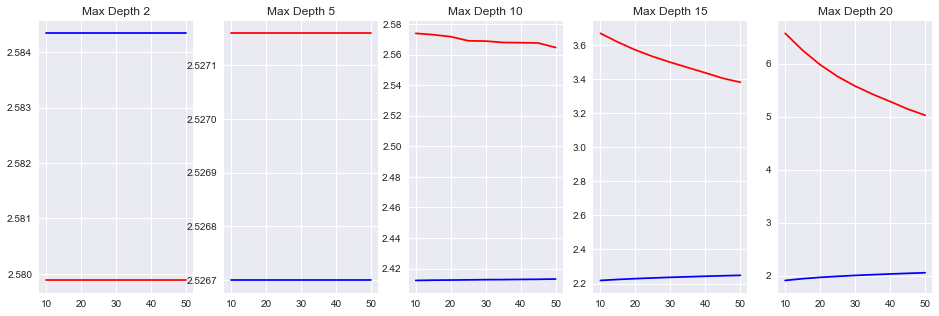

In [80]:
fig, axes = plt.subplots(nrows = 1, ncols = len(max_depth), sharex = False, sharey = False, figsize = (16, 5))

for md in range(len(max_depth)):
    ax = plt.subplot(1, len(max_depth), md + 1)
    ax.plot(min_samples_split, dtc_train_scores[md], 'blue')
    ax.plot(min_samples_split, dtc_dev_scores[md], 'red')
    ax.set_title('Max Depth ' + str(max_depth[md]))



We see from the above that higher depths are leading to overfitting on the training data. The dev data log-loss score is increasing with higher depth. From the charts, it looks like a max depth of 5 is ideal, and the Min Sample Size doesn't matter. We will opt for the highest Min Sample Size as this means the model is more generalizable and is most parsimonious.

### Random Forest

In [331]:
parameters={'n_estimators' : [10,15,20,50,100],
            'max_depth': range(2,10,2),
            'max_features': ['sqrt','log2', None],
            'min_samples_split' : range(100,500,50),
            'bootstrap': ['True','False']
           }
rfClf = RandomForestClassifier()
rfClf_search=GridSearchCV(rfClf,parameters,cv=3,n_jobs=-1,verbose=1)
rfClf_optim = rfClf_search.fit(train_data_v2,train_labels_v2)


Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 90.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 184.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 335.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 426.6min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 611.0min finished


In [335]:
print(rfClf_optim.cv_results_['params'][rfClf_optim.best_index_])
print(rfClf_optim.best_score_)

{'bootstrap': 'True', 'max_depth': 8, 'max_features': None, 'min_samples_split': 350, 'n_estimators': 20}
0.25504686681396777


In [338]:
# Choose the best model and train for predictions on test data

rfClf = RandomForestClassifier(bootstrap=True,max_depth=8,max_features=None,min_samples_split=350,n_estimators=20,n_jobs=-1,verbose=1)
rfClf.fit(train_data_v2,train_labels_v2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   46.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    2.0s finished


(884262,)


## AdaBoosted Decision Trees

We investigated adaboosting as these have been known to perform well for samples with skewed classes

In [56]:
dt_stump=DecisionTreeClassifier(max_depth=8, min_samples_split=20)
dt_stump.fit(train_data_v2, train_labels_v2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [57]:
# Testing the Adaboost method with various n estimators and learning rates. 
# We find the log-loss score of both the training and the dev dataset to ensure we aren't overfitting on the training dataset

n_estimators = [20, 50, 100, 200, 400]
learning_rate = [0.1, 0.5, 0.9]
ada_train_scores = np.zeros((len(learning_rate), len(n_estimators)))
ada_dev_scores = np.zeros((len(learning_rate), len(n_estimators)))
                 
for idx_n, n in enumerate(n_estimators):
    for idx_lr, lr in enumerate(learning_rate):
        print('Training Model for n_estimators of', n, 'with a learning rate of', lr)
        ada_real = AdaBoostClassifier(
            base_estimator=dt_stump,
            learning_rate = lr,
            n_estimators = n,
            algorithm="SAMME.R")
        ada_train_predict = ada_real.fit(train_data_v2, train_labels_v2).predict_proba(train_data_v2)
        ada_train_score = metrics.log_loss(train_labels_v2, ada_train_predict)
        ada_train_scores[idx_lr, idx_n] = ada_train_score
        
        ada_dev_predict = ada_real.predict_proba(dev_data_v2)
        ada_dev_score = metrics.log_loss(dev_labels_v2, ada_dev_predict)
        ada_dev_scores[idx_lr, idx_n] = ada_dev_score
        
print(ada_train_scores)
print(ada_dev_scores)

# OLD CODE
# ada_real.fit(train_data_v2, train_labels_v2)
# ada_pred = ada_real.predict_proba(dev_data_v2)
# score = ada_real.score(dev_data_v2, dev_labels_v2)
# print(ada_score)

Training Model for n_estimators of 20 with a learning rate of 0.1
Training Model for n_estimators of 20 with a learning rate of 0.5
Training Model for n_estimators of 20 with a learning rate of 0.9
Training Model for n_estimators of 50 with a learning rate of 0.1
Training Model for n_estimators of 50 with a learning rate of 0.5
Training Model for n_estimators of 50 with a learning rate of 0.9
Training Model for n_estimators of 100 with a learning rate of 0.1
Training Model for n_estimators of 100 with a learning rate of 0.5
Training Model for n_estimators of 100 with a learning rate of 0.9
Training Model for n_estimators of 200 with a learning rate of 0.1
Training Model for n_estimators of 200 with a learning rate of 0.5
Training Model for n_estimators of 200 with a learning rate of 0.9
Training Model for n_estimators of 400 with a learning rate of 0.1
Training Model for n_estimators of 400 with a learning rate of 0.5
Training Model for n_estimators of 400 with a learning rate of 0.9
[

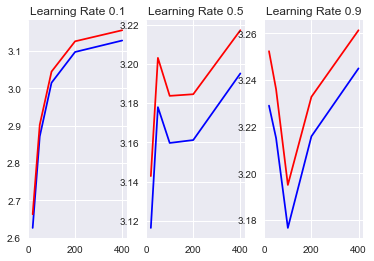

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False)

for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    ax.plot(n_estimators, ada_train_scores[i], 'blue')
    ax.plot(n_estimators, ada_dev_scores[i], 'red')
    ax.set_title('Learning Rate ' + str(learning_rate[i]))



We see the best log-loss scores are coming from models where the learning rate is small (0.1) and n_estimators is a small value (20). From the plots above, we demonstrated that we are not overfitting the model on the traiing dataset here, as the log-loss curves of the dev dataset closely mirror the training dataset.

In [61]:
# Now exploring the model for the optimized set of parameters found above

ada_real_optimized = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate = 0.1,
    n_estimators = 20,
    algorithm="SAMME.R")

ada_real_optimized.fit(train_data_v2, train_labels_v2)
ada_train_optimized_predict = ada_real_optimized.predict_proba(dev_data_v2)

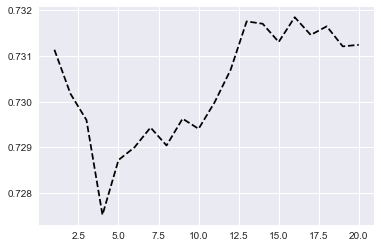

In [62]:
# Plotting the error rate over the number of trees

n_trees_real = len(ada_real_optimized)
real_test_errors = []

for real_test_predict in ada_real_optimized.staged_predict(dev_data_v2):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, dev_labels_v2))
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed', label='SAMME.R')

## Neural network

In [62]:
import tensorflow as tf
from tensorflow import keras

config = tf.ConfigProto()
config.intra_op_parallelism_threads = 0
config.inter_op_parallelism_threads = 0

In [63]:
print(len(data_classes_v2))
print(train_data_v2.shape)

37
(702363, 87)


In [64]:
modelNN = keras.Sequential([
    keras.layers.Flatten(input_shape=(train_data_v2.shape[1],)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(len(data_classes_v2), activation=tf.nn.softmax)
])

Instructions for updating:
Colocations handled automatically by placer.


In [65]:
modelNN.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
modelNN.fit(train_data_v2,train_labels_v2, epochs=5,batch_size=1000)


Epoch 1/5
702363/702363 [==============================] - 4s 5us/sample - loss: 2.6560 - acc: 0.2193
Epoch 2/5
702363/702363 [==============================] - 4s 5us/sample - loss: 2.5618 - acc: 0.2309
Epoch 3/5
702363/702363 [==============================] - 4s 5us/sample - loss: 2.5508 - acc: 0.2318
Epoch 4/5
702363/702363 [==============================] - 4s 5us/sample - loss: 2.5439 - acc: 0.2335
Epoch 5/5
702363/702363 [==============================] - 4s 5us/sample - loss: 2.5393 - acc: 0.2348


In [67]:
val_loss, val_acc = modelNN.evaluate(dev_data_v2,dev_labels_v2)

print('Test accuracy:', val_acc)

175591/175591 [==============================] - 5s 27us/sample - loss: 2.5382 - acc: 0.23503s - loss: 2.54 - ETA: 1s - loss: 2.5387 - acc - ETA: 0s - loss: 2.5387 
Test accuracy: 0.23495509


## Model Choice

#### We chose the random forest classifier as the model for making final predictions on test data

More details on model choice will be included in the final report

## Predictions on test data

*Note:* Test predictions should be an array of probabilities or an array of predicted labels stored in a variable test_pred. Use the proper submission file generator below

In [73]:
# Predict on test data

'''predictions using random forest model'''
#preds = rfClf.predict(test_data_encoded_v2)

## Predictions using neural network model
pred_probs = modelNN.predict(test_data_encoded_v2)
preds = np.argmax(pred_probs,axis=1)

data_classes=data_classes_v2


In [74]:
print(pred_probs[:5])

[[4.72278940e-03 1.15933500e-01 7.35139038e-05 5.68370277e-04
  2.28922479e-02 3.04437988e-03 4.62787645e-03 1.81731470e-02
  6.57960866e-03 1.32543719e-04 1.42107485e-04 5.26604650e-04
  1.78717868e-03 5.67702623e-03 9.51049878e-05 4.21655225e-03
  1.03193238e-01 1.46191986e-03 3.31741699e-04 6.02590293e-02
  8.62145200e-02 1.67536750e-01 6.55433832e-05 1.72969536e-03
  3.45317945e-02 3.92933795e-03 2.46942639e-02 5.82899898e-03
  1.79994648e-04 4.09042137e-03 4.31844383e-04 4.23183627e-02
  5.05054509e-03 7.96974599e-02 1.32491350e-01 3.66604552e-02
  2.01102011e-02]
 [4.72391304e-03 1.16039783e-01 7.34404748e-05 5.68823132e-04
  2.28700507e-02 3.04364716e-03 4.61954391e-03 1.82184745e-02
  6.57644263e-03 1.32368208e-04 1.42031276e-04 5.26622287e-04
  1.78681756e-03 5.67261502e-03 9.51094480e-05 4.21757204e-03
  1.03070922e-01 1.46199728e-03 3.31785239e-04 6.02936558e-02
  8.61815289e-02 1.67694300e-01 6.54622418e-05 1.73176685e-03
  3.45534608e-02 3.92611045e-03 2.47102194e-02 5.826

In [64]:
# Running on MNB model with test data for now, will switch to random forest later
test_pred = mnb_v2_optimized.predict_proba(test_data_encoded_v2)
print(test_pred.shape)

(884262, 39)


### Generating CSV file for submission to Kaggle - Baseline Submission
Our original baseline submission was a KNN model where n = 1. However, we felt it made more sense to make the baseline submission a dataframe which predicts the most common crime for each sample in the test dataset. This will be our model to beat

In [346]:
# Making a baseline submission that just takes the most frequent-occurring crime, and predicting all crimes in the test data frame are of that label

submission_no_ml = pd.DataFrame().reindex_like(sample_submission).fillna(0).astype(int)
submission_no_ml['Id'] = sample_submission['Id']
submission_no_ml['LARCENY/THEFT'] = 1
submission_no_ml.to_csv('baseline_submission_2.csv', index = False)

### Generating CSV file for submission to Kaggle - Use this if using predicted labels

In [70]:
## Print formatted output for submission CSV

# Looking at format of output
#print(sample_submission.head())
print('sample submission shape', sample_submission.shape)

# Now put results in a dataframe 
all_ids = test["Id"].values

# From encoded categories, get normal labels
#labeled_preds = [data_classes[i] for i in preds]
labeled_preds = pred_probs

# Make dateframe
d = {'Id': all_ids, 'Label': labeled_preds}

# Make the results dummy columns
df = pd.DataFrame(data = d)
results = pd.get_dummies(df, prefix=[''],prefix_sep = '')

# To ensure we have all columns, copy data into the schema of sample_submission
submission = pd.DataFrame().reindex_like(sample_submission).fillna(0).astype(int)

col_names = list(results.columns.values)
for col in col_names:
    submission[col] = results[col]

    
print('final shape',submission.shape )
## Save the predictions to submission CSV file
submission.to_csv('submission.csv', index = False)

#print(submission)

sample submission shape (884262, 40)


Exception: Data must be 1-dimensional

### Generating CSV file for submission to Kaggle - Use this for predicted probabilities

In [65]:
print(test_pred[:,0])

# To ensure we have all columns, copy data into the schema of sample_submission
submission = pd.DataFrame().reindex_like(sample_submission).fillna(0).astype(int)

col_names = list(submission.columns.values)
for i, col in enumerate(col_names):
    if col == 'Id':
        submission[col] = sample_submission[col]
    else:
        submission[col] = test_pred[:,i-1]

[0.00888437 0.00768857 0.00463934 ... 0.00075394 0.00075444 0.00075343]


In [66]:
print(submission.shape)

# Comment this out when you are ready to create the CSV object
# submission.to_csv('submission_probs.csv', index = False)

(884262, 40)
